In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/content/amazon_alexa.tsv',delimiter='\t',quoting=3)
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1


In [3]:
df.groupby('rating').verified_reviews.count()

,verified_reviews
rating,
1,161
2,95
3,152
4,455
5,2286


In [4]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
for i in df.columns.values:
  print(i)

rating
date
variation
verified_reviews
feedback


In [6]:
df.isna().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [7]:
df.drop(df[df.verified_reviews.isna()].index,inplace=True)

In [8]:
df.isna().sum()

,0
rating,0
date,0
variation,0
verified_reviews,0
feedback,0


In [9]:
df.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64


In [10]:
df['length']=df['verified_reviews'].apply(lambda x:len(x))

In [11]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [12]:
print(f"lenght:{len(df.verified_reviews.iloc[30])}")
print(f"lenght:{df.length.iloc[30]}")
print(f"review:{df.verified_reviews.iloc[30]}")

lenght:74
lenght:74
review:Still learning all the capabilities...but so far pretty pretty pretty good


In [13]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [14]:
df.groupby('rating').count()['verified_reviews']

,verified_reviews
rating,
1,161
2,95
3,152
4,455
5,2286


In [15]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


##Bar Chart of Rating


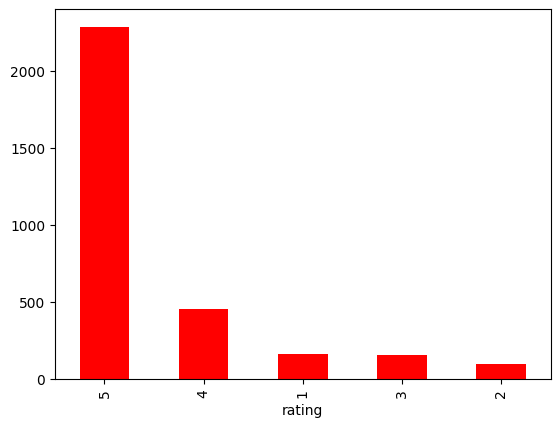

In [16]:
df['rating'].value_counts().plot.bar(color='red')
plt.show()

In [17]:
t = df.shape[0]
round(df['rating'].value_counts()/t*100,2)

,count
rating,
5,72.59
4,14.45
1,5.11
3,4.83
2,3.02


In [18]:
t=df.shape[0]
Min=[]
Max=[]
for i in df.length:
  if (i <= df.length.quantile(0.25)):  # Change condition to use quantile
    Min.append(i)
  else:
    Max.append(i)
print(f"min:{max(Min)}")
print(f"max:{max(Max)}") # Corrected label to 'max'

min:30
max:2853


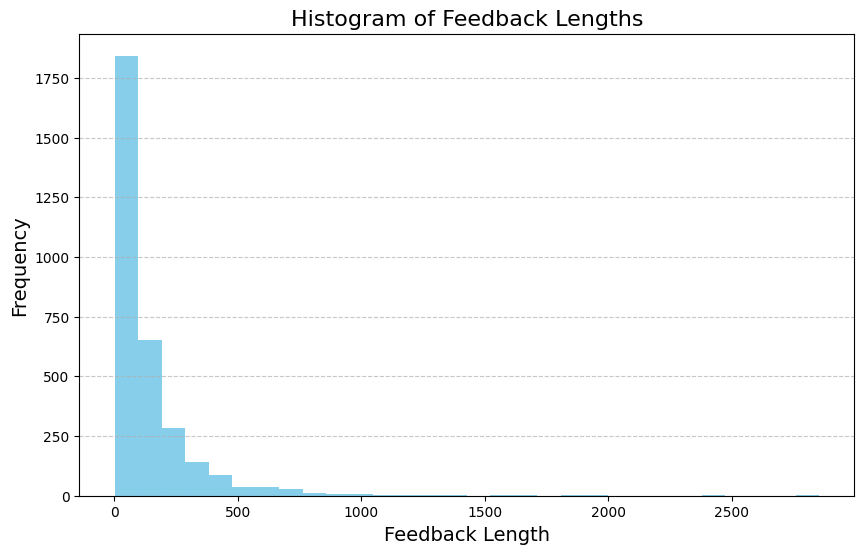

In [19]:
plt.figure(figsize=(10,6))
plt.hist(df.length,bins=30,color='skyblue')
plt.title('Histogram of Feedback Lengths', fontsize=16)
plt.xlabel('Feedback Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Analyzing Feedback columns

##Feedback

0->Negative

1->Positive

In [20]:
df['feedback'].value_counts()

,count
feedback,
1,2893
0,256


In [21]:
df[df['feedback']==0].iloc[0]['verified_reviews']

'"It\'s like Siri, in fact, Siri answers more accurately then Alexa.  I don\'t see a real need for it in my household, though it was a good bargain on prime day deals."'

In [22]:
df[df['feedback']==1].iloc[0]['verified_reviews']

'Love my Echo!'

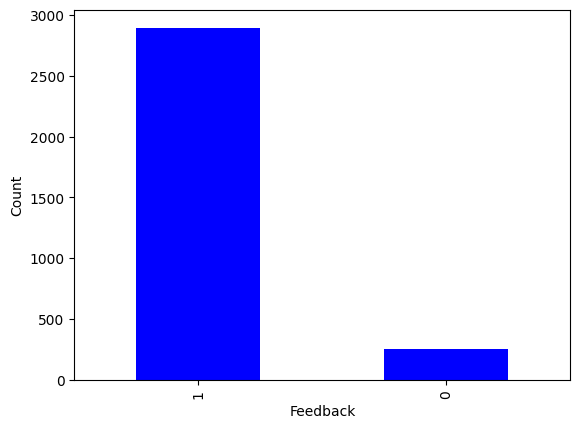

In [23]:
df['feedback'].value_counts().plot.bar(color='blue')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

##Ploting Variation Graph

In [24]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


<Axes: xlabel='variation'>

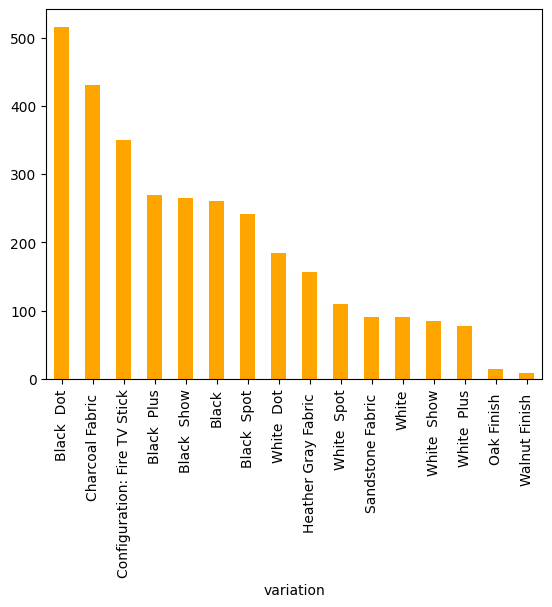

In [25]:
df['variation'].value_counts().plot.bar(color='orange')

<Axes: xlabel='variation'>

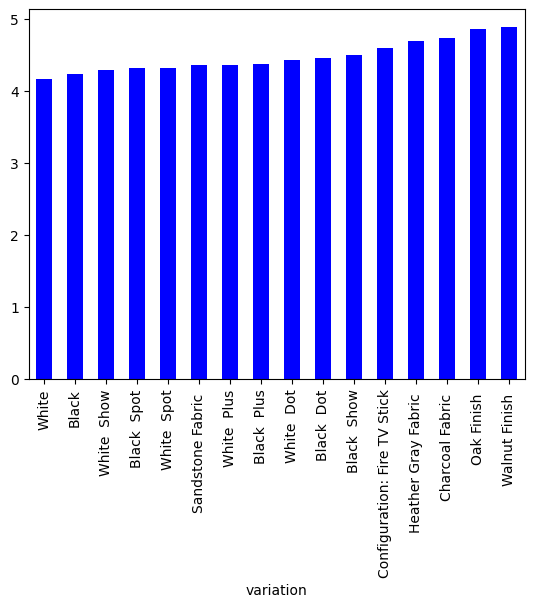

In [26]:
df.groupby('variation')['rating'].mean().sort_values().plot.bar(color='blue')

In [27]:
cv = CountVectorizer(stop_words='english')
word = cv.fit_transform(df.verified_reviews)

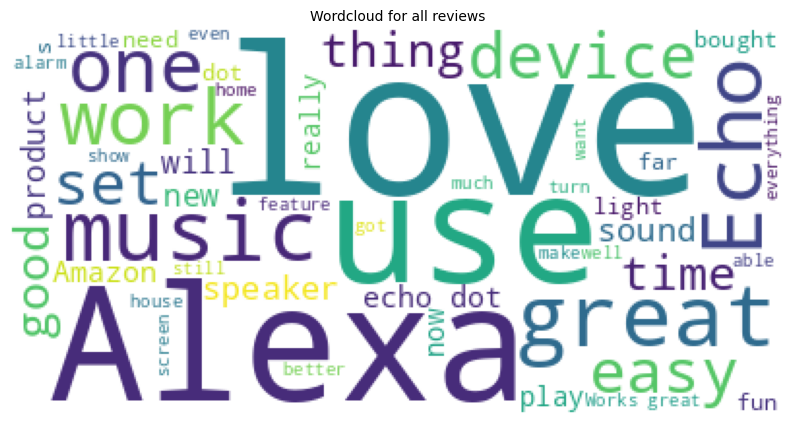

In [28]:
review = " ".join([x for x in df.verified_reviews])
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(review))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [29]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in df[df['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

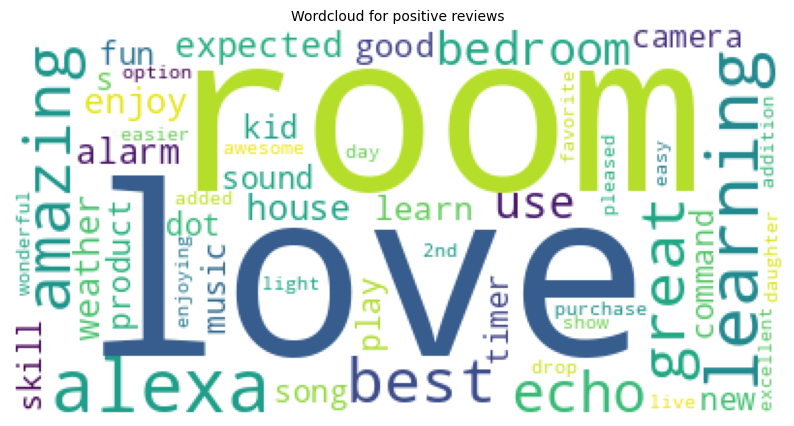

In [30]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

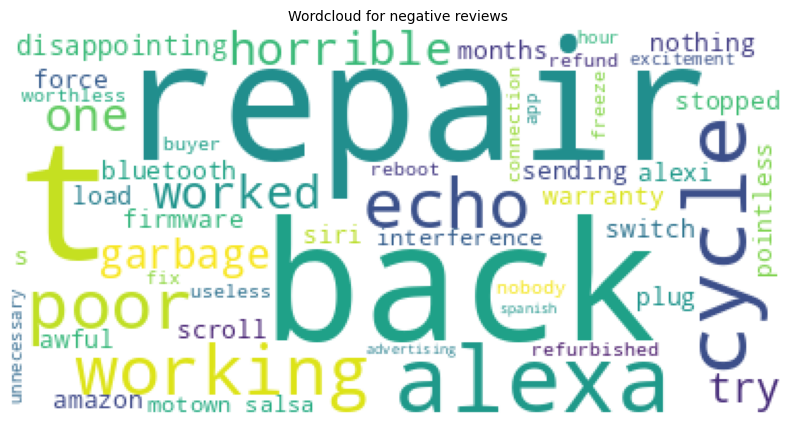

In [31]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

##Preprocessing and Modelling
To build the corpus from the 'verified_reviews' we perform the following -

1.Replace any non alphabet characters with a space

2.Covert to lower case and split into words

3.Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [32]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [33]:
data = df

In [34]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [35]:
#Saving the Count Vectorizer
import os

# Create the 'Models' directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

#Saving the Count Vectorizer

pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [36]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [38]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [39]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [40]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

Random Forest classifier

In [41]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [42]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9417989417989417


In [43]:
y_preds = model_rf.predict(X_test_scl)

In [44]:
cm = confusion_matrix(y_test, y_preds)

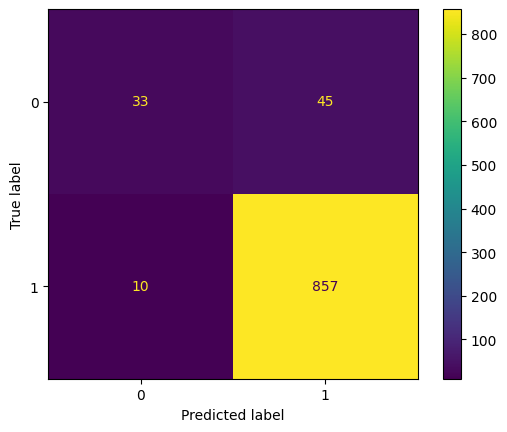

In [45]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [46]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9305841217605924
Standard Variance : 0.007011602058506029


Applying grid search to get the optimal parameters on random forest

In [47]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [48]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [49]:

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [50]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.69351179673322
Cross validation mean accuracy on test set : 92.15063520871144
Accuracy score for test set : 0.9417989417989417


In [59]:
import sklearn
sklearn.set_config(display='text')

In [60]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [52]:
!pip install xgboost==1.7.6

In [53]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9736842105263158
Testing Accuracy : 0.9407407407407408


In [54]:
y_preds = model_xgb.predict(X_test)

In [55]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 33  45]
 [ 14 853]]


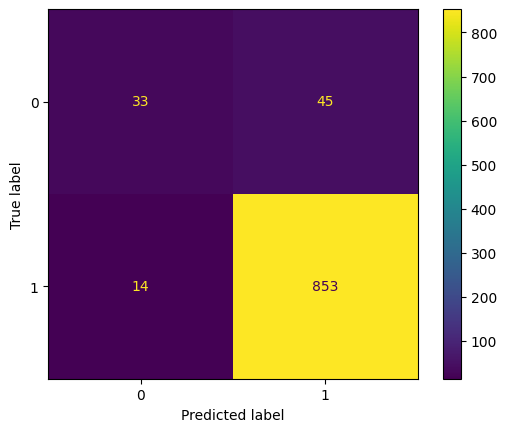

In [56]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [57]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))